# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, Iterator, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from decoder import Decoder
from encoder import Encoder
from attention import Attention
# others
from NMTutils import get_parser, build_data, get_model_config, evaluation, BLEU, show_attention
import random
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.cuda.current_device()
# USE_CUDA = False
# DEVICE = -1

## Prepare Loader

In [4]:
lang1 = 'eng'
lang2 = 'fra'
modelcode_small = ['111301', '111311', '111301', '111311', '111311', 
                  '111311', '111311', '122421', '122521', '122621',
                  '122622', '222421', '222521', '222421']
modelcode_filtered = ['322421', '322421', '322421']

## architecture

![](./pics/encoder_decoder_att.png)

---

## Build Networks

In [5]:
def build(config, SOURCE, TARGET):
    enc = Encoder(len(SOURCE.vocab), config.EMBED, config.HIDDEN, config.NUM_HIDDEN, bidrec=True)
    dec = Decoder(len(TARGET.vocab), config.EMBED, 2*config.HIDDEN, hidden_size2=config.HIDDEN2
                  , sos_idx=SOURCE.vocab.stoi['<s>'], dropout_rate=config.DROPOUT_RATE, method=config.METHOD
                  , USE_CUDA=USE_CUDA)
    if USE_CUDA:
        enc = enc.cuda()
        dec = dec.cuda()

    loss_function = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi['<pad>'])
    return enc, dec, loss_function

In [6]:
def build_model(model_idx, code, lang1, lang2, file_path='./data/en_fa/', file_type='small', device=-1):
    config, test_data, test_loader, SOURCE, TARGET = get_model_config(code, lang1, lang2, device=device,
                                                                      file_path=file_path, file_type=file_type)
    enc, dec, loss_function = build(config, SOURCE, TARGET)
    enc.eval()
    dec.eval()
    
    enc_model_path = './data/model/{0}_{1}/{0}-{1}{2}.enc'.format(lang1, lang2, model_idx)
    dec_model_path = './data/model/{0}_{1}/{0}-{1}{2}.dec'.format(lang1, lang2, model_idx)
    enc.load_state_dict(torch.load(enc_model_path))
    dec.load_state_dict(torch.load(dec_model_path))
    return enc, dec, loss_function, test_loader, test_data

## Load model parameters & test

It's not proper way using "cross entropy loss" to measure translation is translated well. Better use BLEU score.

In [7]:
for i, code in enumerate(modelcode_small, 1):
    enc, dec, loss_function, test_loader, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                                          file_type='small', device=DEVICE)
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 1 | test_losses: 3.3667202830314635
model 2 | test_losses: 2.8526444315910338
model 3 | test_losses: 2.1374758958816527
model 4 | test_losses: 2.0235490083694456
model 5 | test_losses: 2.0051129758358
model 6 | test_losses: 1.9583046078681945
model 7 | test_losses: 1.9079112112522125
model 8 | test_losses: 2.050267094373703
model 9 | test_losses: 2.117695140838623
model 10 | test_losses: 2.945192003250122
model 11 | test_losses: 2.02996820807457
model 12 | test_losses: 2.021291160583496
model 13 | test_losses: 2.2310065746307375
model 14 | test_losses: 2.2038675785064696


In [8]:
for i, code in enumerate(modelcode_filtered, 15):
    enc, dec, loss_function, test_loader, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                                          file_type='filtered', device=DEVICE)
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 15 | test_losses: 2.199345552921295
model 16 | test_losses: 2.22243937253952
model 17 | test_losses: 2.1890329360961913


## Visualize Attention And Scroing

### BLEU

1. Prepare a data set, 1 source to many references sentences.
2. Count **N-Gram** in hypothesis(which is your output sentences): $Count(Ngram)$
3. For **N-Gram** words, count these words in references sentences: $Count_{clip}(Ngram)$
4. Combine:
$$p_n = \dfrac{\sum_{Ngram \in y} Count_{clip}(Ngram)}{\sum_{Ngram \in y} Count(Ngram)}$$
5. Calculate BLEU score:
$$BLEU = BP \times \exp(\dfrac{1}{N} \sum_{n=1}^N p_n)$$
which, $BP= \begin{cases}1\quad if\ len(hypothesis) > len(reference) \\ 
\exp(1-\frac{len(hypothesis)}{len(reference)}) \quad otherwise \end{cases}$ 


Why not use Precision?

$$Precision = \dfrac{TRUE\ detections}{whole\ detections\ of\ an\ algorithm}$$

**Precision** means how many apperance of a word that the model predicted are detected in the reference sentences. Like example below

Target:
* Ref1: The cat on the mat
* Ref2: There is a cat on the mat

Output:
* the the the the the the the 

If we use **Precision**, Output Precision = 7/7

Sometimes we modify **TRUE detections** to use the maximum counts of a word in a sentence. But it is not enough to score a sentence generatation.


======== Model 1 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait le . .
BLEU Score:  0.7071
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


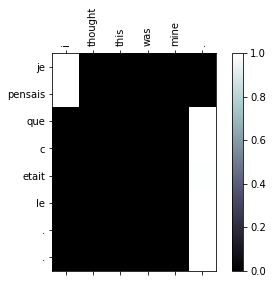

======== Model 2 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je ai que c etait le mienne .
BLEU Score:  0.4273
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


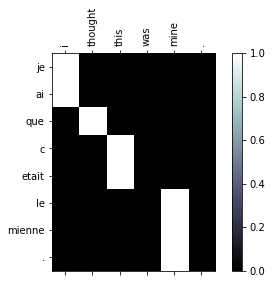

======== Model 3 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je ce que pensais etait le moi .
BLEU Score:  0.259
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


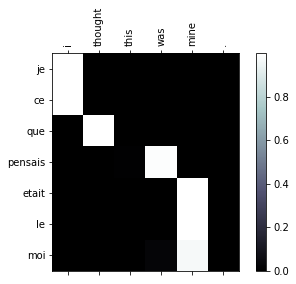

======== Model 4 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait la moi .
BLEU Score:  0.7071
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


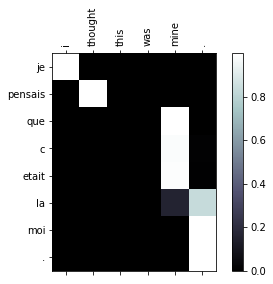

======== Model 5 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait la la .
BLEU Score:  0.7071
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


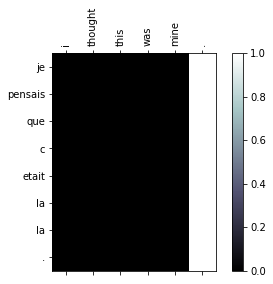

======== Model 6 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  j pensais que c etait la moi .
BLEU Score:  0.5411
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


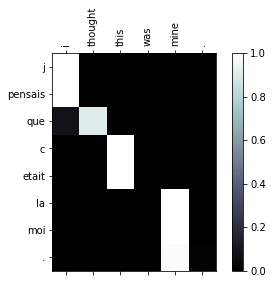

======== Model 7 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait le mien .
BLEU Score:  1.0
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


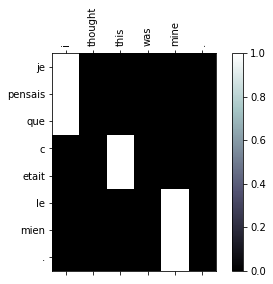

======== Model 8 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je moi que c etait la . .
BLEU Score:  0.3826
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


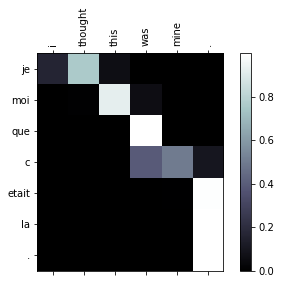

======== Model 9 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait moi moi .
BLEU Score:  0.5411
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


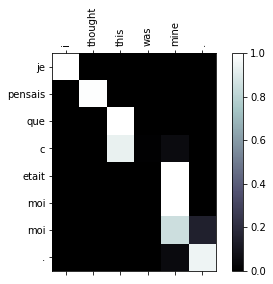

======== Model 10 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je en que c etait
BLEU Score:  0.211
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


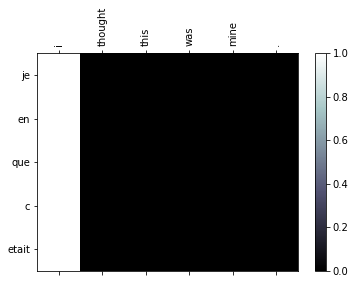

======== Model 11 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  c pensais que c etait moi moi .
BLEU Score:  0.3656
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


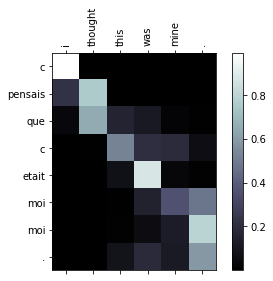

======== Model 12 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que ceci etait a la .
BLEU Score:  0.2851
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


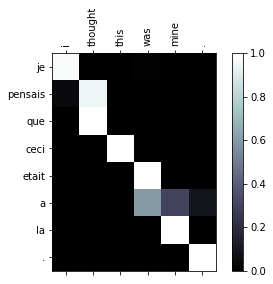

======== Model 13 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait etait . .
BLEU Score:  0.5411
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


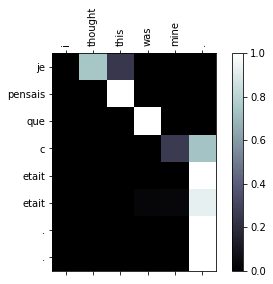

======== Model 14 ========
Source :  i thought this was mine .
Truth :  je pensais que c etait la mienne .
Prediction :  je pensais que c etait la mien .
BLEU Score:  0.7652
References:  ['je pensais que c etait la mienne .', 'je pensais que c etait le mien .']


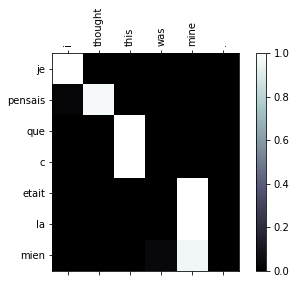

In [9]:
i = 1
file_type = 'small'
model_type = modelcode_small

_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)
bleu = BLEU(test_data, smooth=4)

choose = True
while choose:
    test = random.choice(test_data)
    source_sentence = test.so
    target_sentence = test.ta
    if len(bleu.so_ret_dict[' '.join(source_sentence)]) >= 2:
        choose = False

# change start and target tokens to LongTensor
s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 1):
    enc, dec, _, _, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                    file_type=file_type, device=DEVICE)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    score, ref = bleu.evaluation_bleu(soruce_sentence=' '.join(source_sentence), 
                                      hypotheses=pred_sentence, 
                                      get_ref=True)
    
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))
    print('BLEU Score: ', round(score, 4))
    print('References: ', ref)
    
    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])

======== Model 15 ========
Source :  you should listen to his advice .
Truth :  tu devrais ecouter son conseil .
Prediction :  devriez devriez ecouter ecouter ses . .
BLEU Score:  0.2302
References:  ['tu devrais ecouter son conseil .', 'vous devriez ecouter son conseil .']


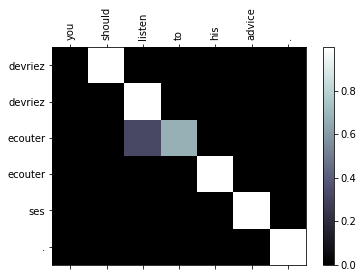

======== Model 16 ========
Source :  you should listen to his advice .
Truth :  tu devrais ecouter son conseil .
Prediction :  tu tu ecouter ecouter son conseils .
BLEU Score:  0.2473
References:  ['tu devrais ecouter son conseil .', 'vous devriez ecouter son conseil .']


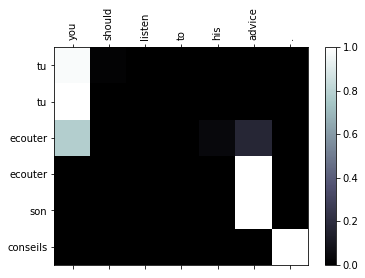

======== Model 17 ========
Source :  you should listen to his advice .
Truth :  tu devrais ecouter son conseil .
Prediction :  tu devriez ecouter son conseil .
BLEU Score:  0.7953
References:  ['tu devrais ecouter son conseil .', 'vous devriez ecouter son conseil .']


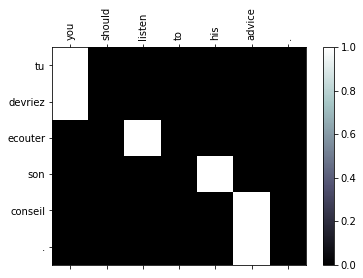

In [12]:
i = 1
file_type = 'filtered'
model_type = modelcode_filtered

_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)
bleu = BLEU(test_data, smooth=4)

choose = True
while choose:
    test = random.choice(test_data)
    source_sentence = test.so
    target_sentence = test.ta
    if len(bleu.so_ret_dict[' '.join(source_sentence)]) >= 2:
        choose = False

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 15):
    enc, dec, _, _, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                    file_type=file_type, device=DEVICE)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    # metrics
    score, ref = bleu.evaluation_bleu(soruce_sentence=' '.join(source_sentence), 
                                      hypotheses=pred_sentence, 
                                      get_ref=True)
    
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))
    print('BLEU Score: ', round(score, 4))
    print('References: ', ref)

    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])

======== Model 18 ========
Source :  you ' re the only canadian i know .
Truth :  tu es le seul canadien que je connaisse .
Prediction :  vous es le seule que que je ' le seule stupide .
BLEU Score:  0.2593
References:  ['tu es la seule canadienne que je connaisse .', 'tu es le seul canadien que je connaisse .']


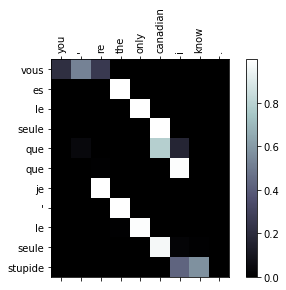

In [21]:
i = 1
file_type = 'filtered2'
model_type = ['222421']

_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)
bleu = BLEU(test_data, smooth=4)

choose = True
while choose:
    test = random.choice(test_data)
    source_sentence = test.so
    target_sentence = test.ta
    if len(bleu.so_ret_dict[' '.join(source_sentence)]) >= 2:
        choose = False

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 18):
    enc, dec, _, _, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                    file_type=file_type, device=DEVICE)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    # metrics
    score, ref = bleu.evaluation_bleu(soruce_sentence=' '.join(source_sentence), 
                                      hypotheses=pred_sentence, 
                                      get_ref=True)
    
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))
    print('BLEU Score: ', round(score, 4))
    print('References: ', ref)

    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])